# Data preparation

Import the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random
import gc
import pyarrow as pa
import pyarrow.parquet
import matplotlib.pyplot as plt
from keras import Input
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv
/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv
/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet


Read the files into pandas object.

In [2]:
path = '/kaggle/input/child-mind-institute-detect-sleep-states/'
train_events = pd.read_csv(path + 'train_events.csv', dtype={
        'series_id': 'str',
        'night': 'UInt16',
        'event': 'str',
        'step': 'UInt32',
    })
train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], utc=True)

series_schema = pa.schema([
    ('series_id', pa.string()),
    ('step', pa.int32()),
    ('timestamp', pa.timestamp('s', tz='UTC')),
    ('anglez', pa.float32()),
    ('enmo', pa.float32())
])
train_series = pyarrow.parquet.read_table(os.path.join(path, 'train_series.parquet'), schema=series_schema).to_pandas()
test_series = pyarrow.parquet.read_table(os.path.join(path, 'test_series.parquet'), schema=series_schema).to_pandas()

Below we can see infos about the train_events object.

In [3]:
train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   series_id  14508 non-null  object             
 1   night      14508 non-null  UInt16             
 2   event      14508 non-null  object             
 3   step       9585 non-null   UInt32             
 4   timestamp  9585 non-null   datetime64[ns, UTC]
dtypes: UInt16(1), UInt32(1), datetime64[ns, UTC](1), object(2)
memory usage: 453.5+ KB


We only extract those events that are not nan.

In [4]:
train_events = train_events[pd.notna(train_events['step'])]

We can see that now they are really the only ones in it

In [5]:
train_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9585 entries, 0 to 14505
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   series_id  9585 non-null   object             
 1   night      9585 non-null   UInt16             
 2   event      9585 non-null   object             
 3   step       9585 non-null   UInt32             
 4   timestamp  9585 non-null   datetime64[ns, UTC]
dtypes: UInt16(1), UInt32(1), datetime64[ns, UTC](1), object(2)
memory usage: 374.4+ KB


Filter out those days where there is only one event.

In [6]:
bad_nights = train_events[['series_id', 'night', 'event']].groupby(by=['series_id', 'night']).count()
bad_nights[((bad_nights['event']!=2) & (bad_nights['event']!=0))]

,,event
series_id,night,
0ce74d6d2106,20,1
154fe824ed87,30,1
44a41bba1ee7,10,1
efbfc4526d58,7,1
f8a8da8bdd00,17,1


Here we can see those events.

In [7]:
train_events[(((train_events['series_id']=='0ce74d6d2106') & (train_events['night']==20)) |
               ((train_events['series_id']=='154fe824ed87') & (train_events['night']==30)) |
               ((train_events['series_id']=='44a41bba1ee7') & (train_events['night']==10)) |
               ((train_events['series_id']=='efbfc4526d58') & (train_events['night']==7)) |
               ((train_events['series_id']=='f8a8da8bdd00') & (train_events['night']==17)))]

,series_id,night,event,step,timestamp
558,0ce74d6d2106,20,onset,332376,2017-09-10 02:08:00+00:00
1425,154fe824ed87,30,wakeup,514980,2019-02-25 14:45:00+00:00
3879,44a41bba1ee7,10,wakeup,165684,2018-03-04 13:07:00+00:00
13553,efbfc4526d58,7,wakeup,114864,2018-12-21 12:47:00+00:00
14105,f8a8da8bdd00,17,wakeup,291384,2017-12-10 17:57:00+00:00


Here we filter out those events.

In [8]:
train_events = train_events[~(((train_events['series_id']=='0ce74d6d2106') & (train_events['night']==20)) |
                              ((train_events['series_id']=='154fe824ed87') & (train_events['night']==30)) |
                              ((train_events['series_id']=='44a41bba1ee7') & (train_events['night']==10)) |
                              ((train_events['series_id']=='efbfc4526d58') & (train_events['night']==7)) |
                              ((train_events['series_id']=='f8a8da8bdd00') & (train_events['night']==17)))].reset_index(drop=True)

train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9580 entries, 0 to 9579
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   series_id  9580 non-null   object             
 1   night      9580 non-null   UInt16             
 2   event      9580 non-null   object             
 3   step       9580 non-null   UInt32             
 4   timestamp  9580 non-null   datetime64[ns, UTC]
dtypes: UInt16(1), UInt32(1), datetime64[ns, UTC](1), object(2)
memory usage: 299.5+ KB


We calculate the shortest sleep time to ensure that each sleep is longer than 30 minutes. Below we can see that the shortest sleep time is 48 minutes.

In [9]:
records_onset = list(train_events[(train_events['event']=='onset')]['step'])
records_wakeup = list(train_events[(train_events['event']=='wakeup')]['step'])

tupleList = (records_onset, records_wakeup)
minimum = 9999999
for onset_item, wakeup_item in zip(*tupleList):
    if (wakeup_item - onset_item) <= minimum:
        minimum = wakeup_item - onset_item
print("This is the sortest sleeping period in minutes: " + str(int(minimum / 12)))

This is the sortest sleeping period in minutes: 48


Here we check if we have a null value or not. And below we can see that there are 269 series.

In [10]:
series_list = list(train_events['series_id'].unique())
print(len(series_list))
train_series = train_series[train_series['series_id'].isin(series_list)].reset_index(drop=True)

train_series.isnull().any()

269


series_id    False
step         False
timestamp    False
anglez       False
enmo         False
dtype: bool

This function splits the dataset into two smaller parts.

In [11]:
def splitTheData(train_series, train_events, selected_series):
    X_train_series = train_series[train_series['series_id'].isin(selected_series)]
    X_val_series = train_series[~train_series['series_id'].isin(selected_series)]
    X_train_events = train_events[train_events['series_id'].isin(selected_series)]
    X_val_events = train_events[~train_events['series_id'].isin(selected_series)]
    return X_train_series, X_val_series, X_train_events, X_val_events

Here we split the dataset into 80%-10%-10% smaller parts.

In [12]:
numberOfSample = int(0.8 * len(series_list))
selected_series = random.sample(series_list, numberOfSample)

X_train_series, X_val_and_test_series, X_train_events, X_val_and_test_series_events = splitTheData(train_series, train_events, selected_series)

series_list_val_and_train = list(X_val_and_test_series_events['series_id'].unique())
numberOfSample = int(0.5 * len(series_list_val_and_train))
selected_series = random.sample(series_list_val_and_train, numberOfSample)

X_val_series, X_test_series, X_val_events, X_test_events = splitTheData(X_val_and_test_series, X_val_and_test_series_events, selected_series)

Here we can see that the train_series contain 215 series and the val_series and the test_series only contain 27 series.

In [13]:
print(len(list(X_train_series['series_id'].unique())))
print(len(list(X_val_series['series_id'].unique())))
print(len(list(X_test_series['series_id'].unique())))

215
27
27


Here we can see the train_series.

In [14]:
X_train_series

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.636700,0.0217
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.636800,0.0215
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.637000,0.0216
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.636800,0.0213
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.636800,0.0215
...,...,...,...,...,...
124822075,fe90110788d2,592375,2017-09-08 04:14:35+00:00,-27.277500,0.0204
124822076,fe90110788d2,592376,2017-09-08 04:14:40+00:00,-27.032499,0.0233
124822077,fe90110788d2,592377,2017-09-08 04:14:45+00:00,-26.841200,0.0202
124822078,fe90110788d2,592378,2017-09-08 04:14:50+00:00,-26.723900,0.0199


Here we can see the train_events

In [15]:
X_train_events

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992,2018-08-15 02:26:00+00:00
1,038441c925bb,1,wakeup,10932,2018-08-15 10:41:00+00:00
2,038441c925bb,2,onset,20244,2018-08-15 23:37:00+00:00
3,038441c925bb,2,wakeup,27492,2018-08-16 09:41:00+00:00
4,038441c925bb,3,onset,39996,2018-08-17 03:03:00+00:00
...,...,...,...,...,...
9575,fe90110788d2,32,wakeup,547152,2017-09-05 13:26:00+00:00
9576,fe90110788d2,33,onset,556560,2017-09-06 02:30:00+00:00
9577,fe90110788d2,33,wakeup,560604,2017-09-06 08:07:00+00:00
9578,fe90110788d2,34,onset,574620,2017-09-07 03:35:00+00:00


We filter out the night column because in the future we don't need this information.

In [16]:
X_train_events = X_train_events[["series_id","event","step", "timestamp"]]
X_val_events = X_val_events[["series_id", "event", "step", "timestamp"]]

This function merge the series and the events into one dataframe.

In [17]:
def merge(X_series, X_events):
    merged = pd.merge(X_series, X_events, on=['series_id', 'step', 'timestamp'], how='outer').reset_index(drop=True)
    X_series = 0
    X_events = 0
    gc.collect()
    return merged

Here we create the train and the validation merged datasets.

In [18]:
train_merged = merge(X_train_series, X_train_events)
val_merged = merge(X_val_series, X_val_events)

Here we can see the val_merged dataset.

In [19]:
val_merged

,series_id,step,timestamp,anglez,enmo,event
0,0cd1e3d0ed95,0,2017-12-08 20:00:00+00:00,-19.953600,0.0217,NaN
1,0cd1e3d0ed95,1,2017-12-08 20:00:05+00:00,-27.766800,0.1193,NaN
2,0cd1e3d0ed95,2,2017-12-08 20:00:10+00:00,-30.888300,0.0577,NaN
3,0cd1e3d0ed95,3,2017-12-08 20:00:15+00:00,-60.787998,0.0647,NaN
4,0cd1e3d0ed95,4,2017-12-08 20:00:20+00:00,-59.281399,0.0168,NaN
...,...,...,...,...,...,...
14079775,fa149c3c4bde,406795,2018-09-23 11:59:35+00:00,-35.089500,0.0116,NaN
14079776,fa149c3c4bde,406796,2018-09-23 11:59:40+00:00,-32.477699,0.0163,NaN
14079777,fa149c3c4bde,406797,2018-09-23 11:59:45+00:00,-15.008000,0.0390,NaN
14079778,fa149c3c4bde,406798,2018-09-23 11:59:50+00:00,-5.407700,0.0121,NaN


This function making the sleep column. When people sleeping the asleep column set to 1 otherwise 0.

In [20]:
def sleepMaking(data):
    records_onset = list(data[(data['event']=='onset')].index)
    data['sleep'] = data['event']
    data['sleep'].replace({'onset': 0, 'wakeup':1}, inplace=True)
    data['sleep'].bfill(axis = 'rows', inplace=True)
    data.loc[records_onset, 'sleep'] = 1
    data['sleep'].fillna(0, inplace=True)
    data['sleep'] = data['sleep'].astype('int8')
    data['sleep'] = data['sleep'].astype('int8')
    data['event'].fillna(0, inplace=True)
    return data

Here we get the modified dataframes with the sleeping column.

In [21]:
train_merged_asleep = sleepMaking(train_merged)
val_merged_asleep = sleepMaking(val_merged)
train_merged = 0
val_merged = 0
gc.collect()

0

Here we can see the modified dataframe.

In [22]:
train_merged_asleep

,series_id,step,timestamp,anglez,enmo,event,sleep
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.636700,0.0217,0,0
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.636800,0.0215,0,0
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.637000,0.0216,0,0
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.636800,0.0213,0,0
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.636800,0.0215,0,0
...,...,...,...,...,...,...,...
98239675,fe90110788d2,592375,2017-09-08 04:14:35+00:00,-27.277500,0.0204,0,0
98239676,fe90110788d2,592376,2017-09-08 04:14:40+00:00,-27.032499,0.0233,0,0
98239677,fe90110788d2,592377,2017-09-08 04:14:45+00:00,-26.841200,0.0202,0,0
98239678,fe90110788d2,592378,2017-09-08 04:14:50+00:00,-26.723900,0.0199,0,0


Making the derived columns. We making a a 7 long rolling window which is a moving average for enmo. In addition we make an 'enmo_lag' column which is the value of the last timestamp's enmo column. We don't make rolling window and 'enmo_lag' for anglez because we don't use it during the training.

In [23]:
def derivedColumns(data):
    data['enmo_rolling'] = data['enmo'].rolling(window=7).mean()
    data['enmo_lag'] = data['enmo'].shift(1)
    data['enmo_rolling'].bfill(inplace=True)
    data['enmo_lag'].bfill(inplace=True)
    return data

We are doing this for each dataframe.

In [ ]:
train_derived = derivedColumns(train_merged_asleep)
val_derived = derivedColumns(val_merged_asleep)
X_test_derived = derivedColumns(X_test_series)
train_merged_asleep = 0
val_merged_asleep = 0
gc.collect()

Here we can see the train_derived dataframe.

In [25]:
train_derived

,series_id,step,timestamp,anglez,enmo,event,sleep,enmo_rolling,enmo_lag
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.636700,0.0217,0,0,0.021571,0.0217
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.636800,0.0215,0,0,0.021571,0.0217
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.637000,0.0216,0,0,0.021571,0.0215
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.636800,0.0213,0,0,0.021571,0.0216
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.636800,0.0215,0,0,0.021571,0.0213
...,...,...,...,...,...,...,...,...,...
98239675,fe90110788d2,592375,2017-09-08 04:14:35+00:00,-27.277500,0.0204,0,0,0.020314,0.0203
98239676,fe90110788d2,592376,2017-09-08 04:14:40+00:00,-27.032499,0.0233,0,0,0.020829,0.0204
98239677,fe90110788d2,592377,2017-09-08 04:14:45+00:00,-26.841200,0.0202,0,0,0.020786,0.0233
98239678,fe90110788d2,592378,2017-09-08 04:14:50+00:00,-26.723900,0.0199,0,0,0.020714,0.0202


In [26]:
gc.collect()

0

Around 18-19 hour only a few people fall asleep. So this will be the middle of the non-sleeping intervals.

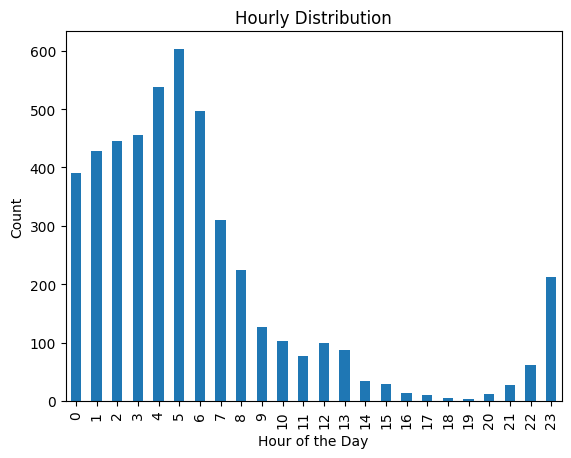

In [27]:
subset_series = train_series.loc[records_onset, 'timestamp']
hour_counts = subset_series.dt.hour.value_counts()
hour_counts = hour_counts.sort_index()
hour_counts.plot.bar()

plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.title('Hourly Distribution')

plt.show()

These function making the intervals for the training dataset and the validation dataset.

In [28]:
#the onset event will be the middle of this window
def getOnsetIntervals(data):
    records_onset = list(data[(data['event']=='onset')].index)
    intervals = []
    for idx in records_onset:
        intervals.append(data.iloc[idx - 100 : idx + 100])
    return intervals

#the wakeup event will be the middle of this window
def getWakeupIntervals(data):
    records_wakeup = list(data[(data['event']=='wakeup')].index)
    intervals = []
    for idx in records_wakeup:
        intervals.append(data.iloc[idx - 99 : idx + 101])
    return intervals

# 585 timestamp is the shortest sleep duration, so if we take the timestamps from the 200th
# timestamp to the 400th timestamp after the onset event, the person will definitely sleep.
def getSleepingIntervals(data):
    records_onset = list(data[(data['event']=='onset')].index)
    intervals = []
    for idx in records_onset:
        intervals.append(data.iloc[idx + 200 : idx + 400])
    return intervals


# getting the nonsleep intervals. We get the 18:00:00 timestamp because in this hour only a few people
# sleeping and we get a 200 long window from this interval.
def getNotSleepingIntervals(data):
    records_onset = len(list(data[(data['event']=='onset')].index))
    time = pd.to_datetime('18:00:00').time()
    notSleepingBeginning = list(data[data['timestamp'].dt.time==time].index)
    intervals = []
    for i in range(records_onset):
        intervals.append(data.iloc[notSleepingBeginning[i] : notSleepingBeginning[i] + 200])
    return intervals

# Making the validation dataset

Here we are making the datasets for training.

In [29]:
def makingData(data):
    #making the four dataset
    onsetInterval = getOnsetIntervals(data)
    wakeupInterval = getWakeupIntervals(data)
    sleepingInterval = getSleepingIntervals(data)
    notsleepingInterval = getNotSleepingIntervals(data)

    #concat
    onsetConcat = pd.concat(onsetInterval, ignore_index=True)
    wakeupConcat = pd.concat(wakeupInterval, ignore_index=True)
    sleepingConcat = pd.concat(sleepingInterval, ignore_index=True)
    notsleepingConcat = pd.concat(notsleepingInterval, ignore_index=True)

    #drop the columns
    onsetConcat.drop(['timestamp', 'event'], axis=1, inplace=True)
    wakeupConcat.drop(['timestamp', 'event'], axis=1, inplace=True)
    sleepingConcat.drop(['timestamp', 'event'], axis=1, inplace=True)
    notsleepingConcat.drop(['timestamp', 'event'], axis=1, inplace=True)

    #separate the labels and targets. We don't use anglez for the training.
    features = ['enmo', 'enmo_rolling', 'enmo_lag']
    label = ['sleep']
    x_onset = onsetConcat[features]
    y_onset = onsetConcat[label]
    x_wakeup = wakeupConcat[features]
    y_wakeup = wakeupConcat[label]
    x_sleeping = sleepingConcat[features]
    y_sleeping = sleepingConcat[label]
    x_notsleeping = notsleepingConcat[features]
    y_notsleeping = notsleepingConcat[label]

    #to numpy and reshape into (n_samples, timesteps, features)
    x_onset = x_onset.to_numpy().reshape(len(onsetInterval), 200, 3)
    y_onset = y_onset.to_numpy().reshape(len(onsetInterval), 200)
    x_wakeup = x_wakeup.to_numpy().reshape(len(wakeupInterval), 200, 3)
    y_wakeup = y_wakeup.to_numpy().reshape(len(wakeupInterval), 200)
    x_sleeping = x_sleeping.to_numpy().reshape(len(sleepingInterval), 200, 3)
    y_sleeping = y_sleeping.to_numpy().reshape(len(sleepingInterval), 200)
    x_notsleeping = x_notsleeping.to_numpy().reshape(len(notsleepingInterval), 200, 3)
    y_notsleeping = y_notsleeping.to_numpy().reshape(len(notsleepingInterval), 200)

    #concatenate
    X_data = np.concatenate((x_onset, x_wakeup), axis=0)
    X_data = np.concatenate((X_data, x_sleeping), axis=0)
    X_data = np.concatenate((X_data, x_notsleeping), axis=0)
    Y_data = np.concatenate((y_onset, y_wakeup), axis=0)
    Y_data = np.concatenate((Y_data, y_sleeping), axis=0)
    Y_data = np.concatenate((Y_data, y_notsleeping), axis=0)
    return X_data, Y_data

Getting the validation and training datasets.

In [30]:
val_X, val_Y = makingData(val_derived)

train_X, train_Y = makingData(train_derived)

In [31]:
val_derived = 0
train_derived = 0
gc.collect()

0

Here we see the shapes of them.

In [32]:
print(val_X.shape)
print(val_Y.shape)
print(train_X.shape)
print(train_Y.shape)

(1920, 200, 3)
(1920, 200)
(15404, 200, 3)
(15404, 200)


After that we mix them up.

In [33]:
indicesVal = np.random.permutation(val_X.shape[0])
indicesTrain = np.random.permutation(train_X.shape[0])

val_X = val_X[indicesVal]
val_Y = val_Y[indicesVal]
train_X = train_X[indicesTrain]
train_Y = train_Y[indicesTrain]

Using MinMaxScaler for scaling.

In [34]:
scaler = MinMaxScaler()
scaler.fit(train_X.reshape(-1, 3))
train_X = scaler.transform(train_X.reshape(-1, 3)).reshape(-1, 200, 3)
val_X = scaler.transform(val_X.reshape(-1, 3)).reshape(-1, 200, 3)

In [35]:
print(val_X.shape)
print(val_Y.shape)
print(train_X.shape)
print(train_Y.shape)

(1920, 200, 3)
(1920, 200)
(15404, 200, 3)
(15404, 200)


## Model

We are using a Bidirectional LSTM for this model. The input_shape is (n_steps, n_feature). After the first Bidirectional layer we should give back the sequences, so that is why we use return_sequences=True. Then we want to check whether the person is sleeping for all 200 times, so the next LSTM layer contains 200 units and returns these values. The next Dense layer has only one unit, which determines whether a person is asleep or not at a given time.

We are using Adam optimizer and BinaryCrossentropy for loss. In addition we use EarlyStopping and ModelCheckpoint.

In [48]:
patience=5
early_stopping=EarlyStopping(patience=patience, verbose=1)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

n_steps = 200
n_features = 3

model = Sequential()
model.add(Input(shape=(n_steps, n_features)))
model.add(Bidirectional(LSTM(n_steps, return_sequences=True)))
model.add(Bidirectional(LSTM(n_steps, return_sequences=True)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=5e-4), loss=BinaryCrossentropy())

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 200, 400)          326400    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 200, 400)          961600    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 200, 1)            401       
                                                                 
Total params: 1288401 (4.91 MB)
Trainable params: 1288401 (4.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We are training it for 100 epoch with batch_size = 32. After the training we load back the best model.

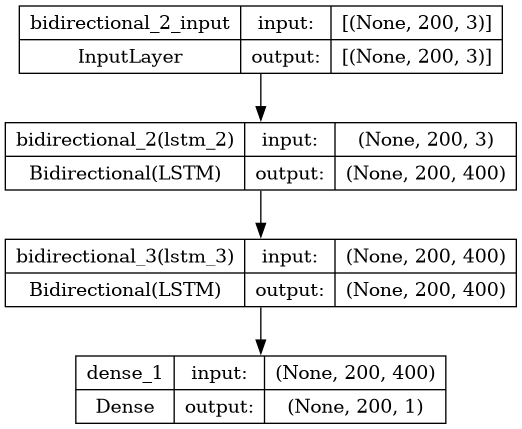

In [82]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [49]:
epochs = 100
history = model.fit(train_X, train_Y,
                    batch_size=32,
                    epochs=epochs,
                    validation_data=(val_X, val_Y),
                    callbacks=[early_stopping, checkpoint])
model.load_weights('best_model.h5')

Epoch 1/100
481/482 [============================>.] - ETA: 0s - loss: 0.4941
Epoch 1: val_loss improved from inf to 0.43056, saving model to best_model.h5
482/482 [==============================] - 31s 48ms/step - loss: 0.4939 - val_loss: 0.4306
Epoch 2/100
481/482 [============================>.] - ETA: 0s - loss: 0.4548
Epoch 2: val_loss improved from 0.43056 to 0.41490, saving model to best_model.h5
482/482 [==============================] - 22s 46ms/step - loss: 0.4548 - val_loss: 0.4149
Epoch 3/100
481/482 [============================>.] - ETA: 0s - loss: 0.3532
Epoch 3: val_loss improved from 0.41490 to 0.28565, saving model to best_model.h5
482/482 [==============================] - 22s 46ms/step - loss: 0.3530 - val_loss: 0.2856
Epoch 4/100
481/482 [============================>.] - ETA: 0s - loss: 0.2815
Epoch 4: val_loss improved from 0.28565 to 0.24610, saving model to best_model.h5
482/482 [==============================] - 22s 45ms/step - loss: 0.2816 - val_loss: 0.2461


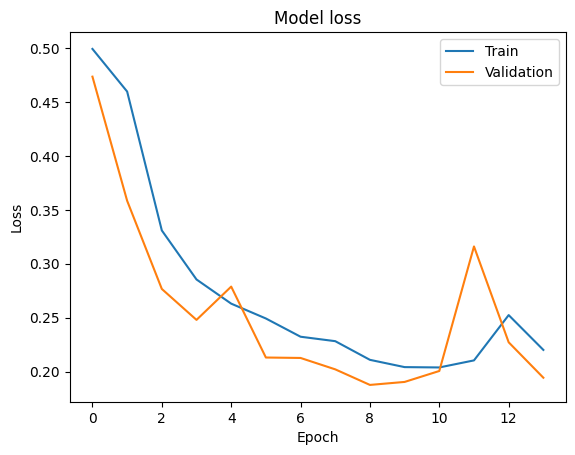

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

The following 4 diagrams show an example for every event (sleep, awake, onset, wakeup), we search for these randomly. If we will run the code again the diagram won't be the same.

In [93]:
test_val = model.predict(val_X[11].reshape(1, 200, 3))

1/1 [==============================] - 0s 41ms/step


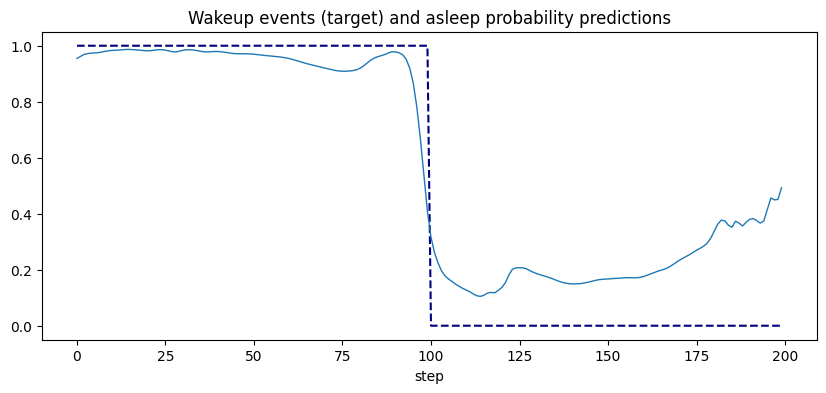

In [94]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.set_title('Wakeup events (target) and asleep probability predictions')
ax.plot(val_Y[11], linestyle='--', color='Navy')
ax.plot(test_val.reshape(200, 1), lw=1)
ax.set_xlabel('step')
plt.show()

In [95]:
test_val1 = model.predict(val_X[2].reshape(1, 200, 3))

1/1 [==============================] - 0s 37ms/step


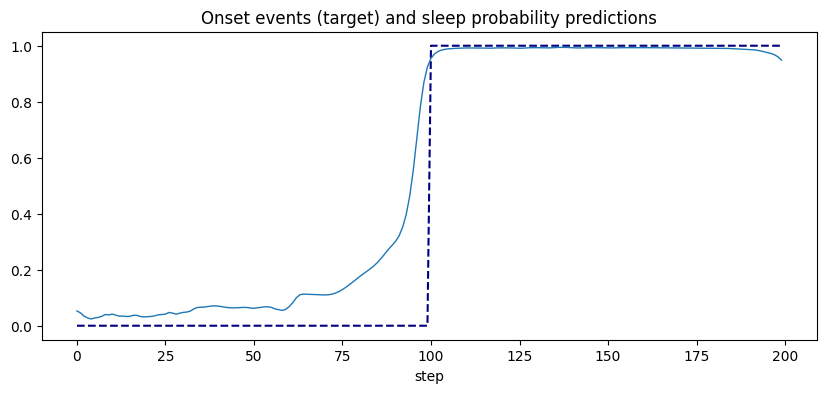

In [97]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.set_title('Onset events (target) and sleep probability predictions')
ax.plot(val_Y[2], linestyle='--', color='Navy')
ax.plot(test_val1.reshape(200, 1), lw=1)
ax.set_xlabel('step')
plt.show()

In [101]:
test_val2 = model.predict(val_X[16].reshape(1, 200, 3))

1/1 [==============================] - 0s 38ms/step


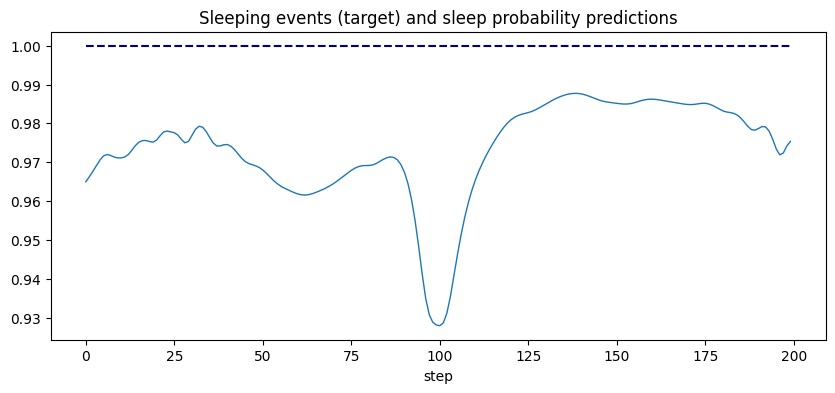

In [102]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.set_title('Sleeping events (target) and sleep probability predictions')
ax.plot(val_Y[16], linestyle='--', color='Navy')
ax.plot(test_val2.reshape(200, 1), lw=1)
ax.set_xlabel('step')
plt.show()

In [115]:
test_val3 = model.predict(val_X[50].reshape(1, 200, 3))

1/1 [==============================] - 0s 36ms/step


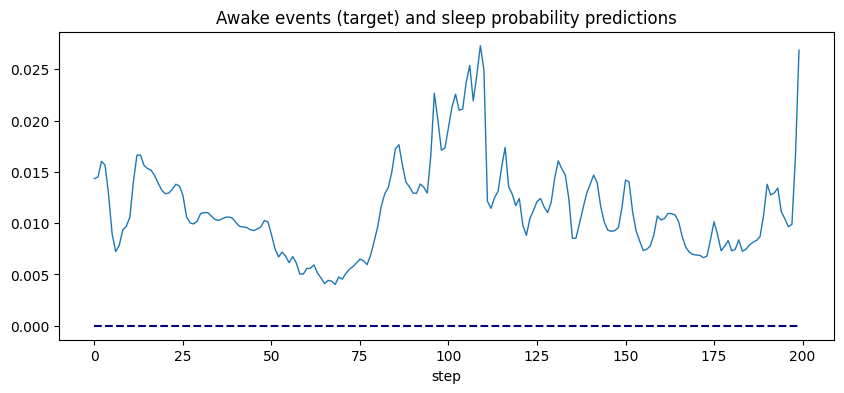

In [117]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.set_title('Awake events (target) and sleep probability predictions')
ax.plot(val_Y[50], linestyle='--', color='Navy')
ax.plot(test_val3.reshape(200, 1), lw=1)
ax.set_xlabel('step')
plt.show()

# Testing

Reset the index of the test series

In [51]:
X_test_derived.reset_index(drop=True, inplace=True)

Here we can see the test series.

In [52]:
X_test_derived

,series_id,step,timestamp,anglez,enmo,enmo_rolling,enmo_lag
0,0402a003dae9,0,2018-12-18 17:45:00+00:00,-77.314903,0.0868,0.061043,0.0868
1,0402a003dae9,1,2018-12-18 17:45:05+00:00,-52.183800,0.0434,0.061043,0.0868
2,0402a003dae9,2,2018-12-18 17:45:10+00:00,-53.218601,0.0541,0.061043,0.0434
3,0402a003dae9,3,2018-12-18 17:45:15+00:00,-51.541698,0.0612,0.061043,0.0541
4,0402a003dae9,4,2018-12-18 17:45:20+00:00,-24.637300,0.0591,0.061043,0.0612
...,...,...,...,...,...,...,...
12502615,f0482490923c,761935,2019-06-26 16:59:35+00:00,4.087200,0.0464,0.054757,0.0474
12502616,f0482490923c,761936,2019-06-26 16:59:40+00:00,7.406800,0.0410,0.052600,0.0464
12502617,f0482490923c,761937,2019-06-26 16:59:45+00:00,6.922200,0.0433,0.049043,0.0410
12502618,f0482490923c,761938,2019-06-26 16:59:50+00:00,17.252199,0.0460,0.046543,0.0433


Here we can see the unique series.

In [53]:
series_list = X_test_derived['series_id'].unique()
print(series_list)

['0402a003dae9' '0dee4fda51c3' '0ec9fc461819' '33ceeba8918a'
 '3aceb17ef7bd' '4a31811f3558' '5f40907ec171' '601559e1777d'
 '60e51cad2ffb' '703b5efa9bc1' '7822ee8fe3ec' '8877a6586606'
 '8898e6db816d' '8b159a98f485' '8f6f15b9f598' '90eac42a9ec9'
 '91cb6c98201f' '9277be28a1cf' '9ee455e4770d' 'a88088855de5'
 'c289c8a823e0' 'c535634d7dcd' 'ccdee561ee5d' 'cf13ed7e457a'
 'dff367373725' 'ebd76e93ec7d' 'f0482490923c']


This function making samples from the series. Splits each series into windows of length 200 and cuts off the end of the series.

In [54]:
def makingSamples(data):
    num_of_samples = data.shape[0] // n_steps
    # These lines are prepared for testing the accuracy of the model.
    if num_of_samples != 0:
        data = data[:num_of_samples*n_steps]
        data = scaler.transform(data.values.reshape(-1, 3)).reshape(num_of_samples, 200, 3)
    # These lines are prepared for submission. During testing the notebook's runnability, each series is limited to 150 timestamps. 
    # However, these samples may not accurately represent the series as each one is longer than 150 timestamps.
    else:
        data = pd.concat([data, data], ignore_index=True)
        data = data[:200]
        data = data.values.reshape((1, n_steps, -1))
    return data

Making the datasets.

In [55]:
def makingTheDatasets(data):
    test_X_by_ids = {}
    features = ['enmo', 'enmo_rolling', 'enmo_lag']

    # getting the series into dictinaries.
    for series_id, series in data.groupby('series_id'):
        test_X_by_ids[series_id] = series[features]
        test_X_by_ids[series_id] = makingSamples(test_X_by_ids[series_id])

    return test_X_by_ids

Making the datasets.

In [56]:
test_X_by_ids = makingTheDatasets(X_test_derived)

Here we can see a specific series shape, the dimension is (number_of_windows, length_of_window, features).

In [85]:
test_X_by_ids[series_list[1]].shape

(2055, 200, 3)

In [58]:
def makingPredictions(data):
    prediction = {}
    for ids in series_list:
        pred = model.predict(data[ids])
        pred = pred.reshape(-1, 1)
        prediction[ids] = pred
    return prediction

In [59]:
pred = makingPredictions(test_X_by_ids)

120/120 [==============================] - 2s 19ms/step


Here we can see the specific series prediction shape.

In [84]:
pred[series_list[1]].shape

(411000, 1)

Here we get the Onset and Wakeup events.

In [61]:
def getOnsetAndWakeupEvents(data):
    dataset = {}
    for ids in series_list:
        dataset[ids] = pd.DataFrame(data=data[ids], columns=['sleep'])

        # we calculate the rolling window because in the prediction can be
        # anomalies and this helps to smooth out it.
        dataset[ids]['sleep_rolling_window'] = dataset[ids]['sleep'].rolling(window=20*12).mean()

        # we predict sleeping for those step, where the probabilities higher than 0.5
        dataset[ids]['sleep'] = np.where(dataset[ids]['sleep_rolling_window'] > 0.5, 1, 0)

        # if the difference is 1, then it is an onset (0-1) and if the
        # difference is -1, then it is a wakeup (1-0) event.
        dataset[ids]['sleep_diff'] = dataset[ids]['sleep'].diff()

        # fill the nan values.
        dataset[ids]['sleep_diff'].bfill(axis='rows', inplace=True)
        dataset[ids]['sleep_diff'].ffill(axis='rows', inplace=True)
        dataset[ids]['sleep_diff']= dataset[ids]['sleep_diff'].astype(int)

        # making step column.
        dataset[ids]['step'] = range(data[ids].shape[0])

        #drop the unnecessary columns.
        dataset[ids].drop(['sleep', 'sleep_rolling_window'], axis=1, inplace=True)
    return dataset

This is the constants for the onset and wakeup events.

In [62]:
EVT_ONSET = 1
EVT_WAKEUP = -1

Getting the events.

In [63]:
OnsetAndWakeupPreds = getOnsetAndWakeupEvents(pred)

Here we can see a specific series output. 1 means it is an onset event, -1 means it is a wakeup event, 0 means it isn't an event.

In [83]:
OnsetAndWakeupPreds[series_list[1]]

,sleep_diff,step
3698,1,3698
4637,-1,4637
4841,1,4841
4936,-1,4936
5332,1,5332
...,...,...
407818,1,407818
408118,-1,408118
408198,1,408198
409138,-1,409138


Getting only the events.

In [66]:
def getEvents(events):
    for ids in series_list:
        events[ids] = events[ids][(events[ids]['sleep_diff'] == EVT_ONSET) | (events[ids]['sleep_diff'] == EVT_WAKEUP)]
    return events

In [67]:
events = getEvents(OnsetAndWakeupPreds)

This function gives back the intervals of the sleepings.

In [68]:
def fit_sleep_periods(events):
    sleeps = {}
    for ids in series_list:
        sleeps[ids] = []
        sleep_start = None
        sleep_end = None
        for event, step in events[ids].values:
            if event == EVT_WAKEUP and sleep_start == None:
                continue
            if event == EVT_ONSET and sleep_start == None:
                sleep_start = step
            if event == EVT_WAKEUP and sleep_start != None:
                sleep_end = step
            if event == EVT_ONSET and sleep_end != None:
                sleeps[ids].append((sleep_start, sleep_end))
                sleep_start = step
                sleep_end = None
        if sleep_end != None:
            sleeps[ids].append((sleep_start, sleep_end))

    return sleeps

Getting the intervals.

In [69]:
eventsPair = fit_sleep_periods(events)

If the sleep period is shorter than 30 minutes filter it out as it's invalid as per the rules.

In [ ]:
def filter_short_sleeps(sleeps):
    return [ (onset, wakeup) for onset, wakeup in sleeps if wakeup - onset >= 30 * 12 ]

Here we filter out the short sleeps.

In [ ]:
for ids in series_list:
    eventsPair[ids] = filter_short_sleeps(eventsPair[ids])

This function merges the short events if there are closer than 60 minutes to each other.

In [70]:
def merge_sleeps(sleeps):
    new_sleeps = {}
    last_wakeup = None
    sleep_start = None
    for ids in series_list:
        new_sleeps[ids] = []
        last_wakeup = None
        sleep_start = None
        for onset, wakeup in sleeps[ids]:
            if last_wakeup is None:
                sleep_start = onset
            elif onset - last_wakeup >= 60 * 12:
                new_sleeps[ids].append((sleep_start, last_wakeup))
                sleep_start = onset
            last_wakeup = wakeup
        if sleep_start is not None:
            new_sleeps[ids].append((sleep_start, last_wakeup))
    return new_sleeps

In [71]:
merged_events = merge_sleeps(eventsPair)

This function assign events to nights, it is necessary for getting the longest sleeping period.

In [72]:
MIDNIGHT_POINT = 2160

def getStartTime(series):
    new_sleeps = {}
    for series_id, series in seriesTest.groupby('series_id'):
        tmp = series.reset_index(drop=True)
        first_timestamp = tmp['timestamp'][0]
        first_step_time = (first_timestamp.hour * 3600 + first_timestamp.minute * 60 + first_timestamp.second) // 5
        new_sleeps[series_id] = (len(tmp), first_step_time)
    return new_sleeps

def assign_to_nights(series_len, start_time, sleep_periods):
    n_nights = (series_len + start_time - MIDNIGHT_POINT) // (24 * 60 * 12) + 2
    sleeps_per_night = [[] for _ in range(0, n_nights)]
    for start, end in sleep_periods:
        mid = int((start + end) / 2)
        night_idx = (mid + start_time - MIDNIGHT_POINT + 12 * 60 * 12) // (24 * 60 * 12)
        sleeps_per_night[night_idx].append((start - 120, end - 120))
    return sleeps_per_night

This function give back to longest sleeping period.

In [73]:
def filter_max_sleeps(sleeps_nights):
    return [ max(sleeps, key=lambda sleep: sleep[1] - sleep[0]) for sleeps in sleeps_nights if sleeps != []]

In this section we getting the longest events for each series.

In [74]:
sleeps_by_ids = {}
startTimeAndLen = getStartTime(X_test_derived)
for ids in series_list:
    sleeps_by_ids[ids] = assign_to_nights(startTimeAndLen[ids][0], startTimeAndLen[ids][1], merged_events[ids])
    sleeps_by_ids[ids] = filter_max_sleeps(sleeps_by_ids[ids])

This plot shows the predicted and true events of a random time series. Red is the predicted sleep period and blue is the true sleep period. The purple color means in the diagram that there is an overlap between the predicted and true periods. We can see, that the prediction is not that bad at all.

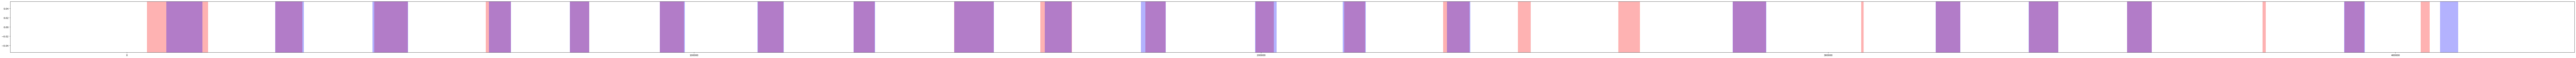

In [87]:
events = X_test_events[X_test_events['series_id']==series_list[1]]
events = events['step'].reset_index(drop=True)

plt.figure(figsize=(200, 4))
for sleep in sleeps_by_ids[series_list[1]]:
    plt.axvspan(sleep[0], sleep[1], color='red', alpha=0.3)
for idx in range(int(len(events)/2)):
    plt.axvspan(events[2*idx], events[2*idx+1], color='blue', alpha=0.3)
plt.plot(0, lw=0.5)
plt.savefig('example1_plot.png')

This function create submission dataframe for submission.

In [76]:
def create_submission_df(series_id, sleeps):
    submission = None
    for onset, wakeup in sleeps:
        sleep_df = pd.DataFrame([
            {'series_id': series_id, 'step': onset, 'event': 'onset', 'score': 1.0},
            {'series_id': series_id, 'step': wakeup, 'event': 'wakeup', 'score': 1.0}
        ])
        if submission is None:
            submission = sleep_df
        else:
            submission = pd.concat([submission, sleep_df], ignore_index=True)
    return submission

In [77]:
submission = None
for series_id in series_list:
    sleeps_df = create_submission_df(series_id, sleeps_by_ids[series_id])
    if submission is None:
        submission = sleeps_df
    else:
        submission = pd.concat([submission, sleeps_df], ignore_index=True)

This is the api which calculate the score. The competition provided this api.

In [78]:
import pandas.api.types
from typing import Dict, List, Tuple


class ParticipantVisibleError(Exception):
    pass


# Set some placeholders for global parameters
series_id_column_name = None
time_column_name = None
event_column_name = None
score_column_name = None
use_scoring_intervals = None
def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, List[float]],
        series_id_column_name: str,
        time_column_name: str,
        event_column_name: str,
        score_column_name: str,
        use_scoring_intervals: bool = False,
) -> float:
    # Validate metric parameters
    assert len(tolerances) > 0, "Events must have defined tolerances."
    assert set(tolerances.keys()) == set(solution[event_column_name]).difference({'start', 'end'}),\
        (f"Solution column {event_column_name} must contain the same events "
         "as defined in tolerances.")
    assert pd.api.types.is_numeric_dtype(solution[time_column_name]),\
        f"Solution column {time_column_name} must be of numeric type."

    # Validate submission format
    for column_name in [
        series_id_column_name,
        time_column_name,
        event_column_name,
        score_column_name,
    ]:
        if column_name not in submission.columns:
            raise ParticipantVisibleError(f"Submission must have column '{target_name}'.")

    if not pd.api.types.is_numeric_dtype(submission[time_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{time_column_name}' must be of numeric type."
        )
    if not pd.api.types.is_numeric_dtype(submission[score_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{score_column_name}' must be of numeric type."
        )

    # Set these globally to avoid passing around a bunch of arguments
    globals()['series_id_column_name'] = series_id_column_name
    globals()['time_column_name'] = time_column_name
    globals()['event_column_name'] = event_column_name
    globals()['score_column_name'] = score_column_name
    globals()['use_scoring_intervals'] = use_scoring_intervals

    return event_detection_ap(solution, submission, tolerances)


def filter_detections(
        detections: pd.DataFrame, intervals: pd.DataFrame
) -> pd.DataFrame:
    """Drop detections not inside a scoring interval."""
    detection_time = detections.loc[:, time_column_name].sort_values().to_numpy()
    intervals = intervals.to_numpy()
    is_scored = np.full_like(detection_time, False, dtype=bool)

    i, j = 0, 0
    while i < len(detection_time) and j < len(intervals):
        time = detection_time[i]
        int_ = intervals[j]

        # If the detection is prior in time to the interval, go to the next detection.
        if time < int_.left:
            i += 1
        # If the detection is inside the interval, keep it and go to the next detection.
        elif time in int_:
            is_scored[i] = True
            i += 1
        # If the detection is later in time, go to the next interval.
        else:
            j += 1

    return detections.loc[is_scored].reset_index(drop=True)


def match_detections(
        tolerance: float, ground_truths: pd.DataFrame, detections: pd.DataFrame
) -> pd.DataFrame:
    """Match detections to ground truth events. Arguments are taken from a common event x tolerance x series_id evaluation group."""
    detections_sorted = detections.sort_values(score_column_name, ascending=False).dropna()
    is_matched = np.full_like(detections_sorted[event_column_name], False, dtype=bool)
    gts_matched = set()
    for i, det in enumerate(detections_sorted.itertuples(index=False)):
        best_error = tolerance
        best_gt = None

        for gt in ground_truths.itertuples(index=False):
            error = abs(getattr(det, time_column_name) - getattr(gt, time_column_name))
            if error < best_error and gt not in gts_matched:
                best_gt = gt
                best_error = error

        if best_gt is not None:
            is_matched[i] = True
            gts_matched.add(best_gt)

    detections_sorted['matched'] = is_matched

    return detections_sorted


def precision_recall_curve(
        matches: np.ndarray, scores: np.ndarray, p: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(matches) == 0:
        return [1], [0], []

    # Sort matches by decreasing confidence
    idxs = np.argsort(scores, kind='stable')[::-1]
    scores = scores[idxs]
    matches = matches[idxs]

    distinct_value_indices = np.where(np.diff(scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
    thresholds = scores[threshold_idxs]

    # Matches become TPs and non-matches FPs as confidence threshold decreases
    tps = np.cumsum(matches)[threshold_idxs]
    fps = np.cumsum(~matches)[threshold_idxs]

    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / p  # total number of ground truths might be different than total number of matches

    # Stop when full recall attained and reverse the outputs so recall is non-increasing.
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)

    # Final precision is 1 and final recall is 0
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def average_precision_score(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
    precision, recall, _ = precision_recall_curve(matches, scores, p)
    # Compute step integral
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])


def event_detection_ap(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, List[float]],
) -> float:

    # Ensure solution and submission are sorted properly
    solution = solution.sort_values([series_id_column_name, time_column_name])
    submission = submission.sort_values([series_id_column_name, time_column_name])

    # Extract scoring intervals.
    if use_scoring_intervals:
        intervals = (
            solution
            .query("event in ['start', 'end']")
            .assign(interval=lambda x: x.groupby([series_id_column_name, event_column_name]).cumcount())
            .pivot(
                index='interval',
                columns=[series_id_column_name, event_column_name],
                values=time_column_name,
            )
            .stack(series_id_column_name)
            .swaplevel()
            .sort_index()
            .loc[:, ['start', 'end']]
            .apply(lambda x: pd.Interval(*x, closed='both'), axis=1)
        )

    # Extract ground-truth events.
    ground_truths = (
        solution
        .query("event not in ['start', 'end']")
        .reset_index(drop=True)
    )

    # Map each event class to its prevalence (needed for recall calculation)
    class_counts = ground_truths.value_counts(event_column_name).to_dict()

    # Create table for detections with a column indicating a match to a ground-truth event
    detections = submission.assign(matched = False)

    # Remove detections outside of scoring intervals
    if use_scoring_intervals:
        detections_filtered = []
        for (det_group, dets), (int_group, ints) in zip(
            detections.groupby(series_id_column_name), intervals.groupby(series_id_column_name)
        ):
            assert det_group == int_group
            detections_filtered.append(filter_detections(dets, ints))
        detections_filtered = pd.concat(detections_filtered, ignore_index=True)
    else:
        detections_filtered = detections

    # Create table of event-class x tolerance x series_id values
    aggregation_keys = pd.DataFrame(
        [(ev, tol, vid)
         for ev in tolerances.keys()
         for tol in tolerances[ev]
         for vid in ground_truths[series_id_column_name].unique()],
        columns=[event_column_name, 'tolerance', series_id_column_name],
    )

    # Create match evaluation groups: event-class x tolerance x series_id
    detections_grouped = (
        aggregation_keys
        .merge(detections_filtered, on=[event_column_name, series_id_column_name], how='left')
        .groupby([event_column_name, 'tolerance', series_id_column_name])
    )
    ground_truths_grouped = (
        aggregation_keys
        .merge(ground_truths, on=[event_column_name, series_id_column_name], how='left')
        .groupby([event_column_name, 'tolerance', series_id_column_name])
    )
    # Match detections to ground truth events by evaluation group
    detections_matched = []
    for key in aggregation_keys.itertuples(index=False):
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        detections_matched.append(
            match_detections(dets['tolerance'].iloc[0], gts, dets)
        )
    detections_matched = pd.concat(detections_matched)

    # Compute AP per event x tolerance group
    event_classes = ground_truths[event_column_name].unique()
    ap_table = (
        detections_matched
        .query("event in @event_classes")
        .groupby([event_column_name, 'tolerance']).apply(
            lambda group: average_precision_score(
                group['matched'].to_numpy(),
                group[score_column_name].to_numpy(),
                class_counts[group[event_column_name].iat[0]],
            )
        )
    )
    # Average over tolerances, then over event classes
    mean_ap = ap_table.groupby(event_column_name).mean().sum() / len(event_classes)

    return mean_ap

Here we can see the true events.

In [79]:
X_test_events

,series_id,night,event,step,timestamp
54,0402a003dae9,1,onset,8364,2018-12-19 05:22:00+00:00
55,0402a003dae9,1,wakeup,12948,2018-12-19 11:44:00+00:00
56,0402a003dae9,2,onset,24396,2018-12-20 03:38:00+00:00
57,0402a003dae9,2,wakeup,29964,2018-12-20 11:22:00+00:00
58,0402a003dae9,6,onset,94032,2018-12-24 04:21:00+00:00
...,...,...,...,...,...
9111,f0482490923c,13,wakeup,221892,2019-05-26 10:56:00+00:00
9112,f0482490923c,14,onset,232356,2019-05-27 01:28:00+00:00
9113,f0482490923c,14,wakeup,239220,2019-05-27 11:00:00+00:00
9114,f0482490923c,16,onset,267384,2019-05-29 02:07:00+00:00


Here we can see the predicted events.

In [80]:
submission

,series_id,step,event,score
0,0402a003dae9,5492,onset,1.0
1,0402a003dae9,12892,wakeup,1.0
2,0402a003dae9,24424,onset,1.0
3,0402a003dae9,29999,wakeup,1.0
4,0402a003dae9,37311,onset,1.0
...,...,...,...,...
1423,f0482490923c,717598,wakeup,1.0
1424,f0482490923c,734601,onset,1.0
1425,f0482490923c,734876,wakeup,1.0
1426,f0482490923c,751734,onset,1.0


This is the score of the evaluation. 0.325 is not so bad. However, it depends on what series are in the test_series dataset.

In [118]:
tolerances = {"onset": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
             "wakeup": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}
print(score(X_test_events, submission, tolerances, "series_id", "step", "event", "score"))

0.3250234952368747
